# SkimLit Project: Natural Language Processing

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper to be replicated/the dataset source is available here: https://arxiv.org/pdf/1710.06071.pdf

The model architecture they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

## Preparation

In [42]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow_hub as hub

Helper functions

In [2]:
def get_lines(filename):
  """
  reads filename (a text filename) and returns the lines of text as a list.

  args:
  filenmae: a string containing the target filepath.

  returns:
  a list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()
    

In [3]:
def split_chars(text):
  return " ".join(list(text)) # split sentences into chars
  

In [4]:
def preprocess_text_with_line_numbers(filename):
  """
  returns a list of dictionaries of abstract line data.

  takes in filename, reads its contents, and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract, and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename)
  abstract_samples = [] # create an empty list of abstracts
  abstract_lines = "" # create an empty abstract

  # format:
  # [{'line_number':0, 
  # 'target':'BACKGROUND', 
  # 'text':"emotional eating... .\n", 
  # 'total_lines':11}, ...]'

  for line in input_lines:
    if line.startswith("#"):
      # beginning of a new abstract
      abstract_lines = "" # reset abstract string      

    elif line.isspace(): 
      # end of an abstract
      # go back through all of the abstract lines stored in abstract_lines
      abstract_line_split = abstract_lines.splitlines() # separate the lines

      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        new_line = {}
        break_sentence = abstract_line.split('\t')
        new_line["line_number"] = abstract_line_number
        new_line["target"] = break_sentence[0]
        new_line["text"] = break_sentence[1].lower()
        new_line["total_lines"] = len(abstract_line_split)-1
        abstract_samples.append(new_line)

    else:
      # this is neither the beginning nor the end of an abstract
      # add it to the strings in the abstract
      # the line contains a labeled sentence
      abstract_lines += line

  return abstract_samples
  

In [5]:
def calculate_results(y_true, y_pred):
  """
  calculates model accuracy, precision, recall and f1 score of a binary classification model.

  args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

Retrieve data

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 14.11 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [7]:
get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

## Run the limited dataset

In [8]:
main_data_dir_20k = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

train_dir = main_data_dir_20k+"train.txt"
val_dir = main_data_dir_20k+"dev.txt"
test_dir = main_data_dir_20k+"test.txt"

train_samples = preprocess_text_with_line_numbers(train_dir)
val_samples = preprocess_text_with_line_numbers(val_dir)
test_samples = preprocess_text_with_line_numbers(test_dir)

In [9]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [12]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

In [13]:
train_chars = [split_chars(sentence) for sentence in train_sentences] 
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

Label encoder creation

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# using sklearn.preprocessing.LabelEncoder()
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# using sklearn.preprocessing.OneHotEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# using tf.one_hot
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

Build a tribrid embedding model:

1. Create a token-level model.
2. Create a character-level model.
3. Create a model for the "line_number" feature.
4. Create a model for the "total_lines" feature.
5. Concatenate 1 and 2.
6. Concatenate 3, 4, and 5.
7. Create an output layer to accept the tribrid embedding.and output label probabilities.
8. Combine inputs of 1, 2, 3, and 4 and outputs of 7 into a tf.keras.Model.

Token model creation (with Universal Sentence Encoder)

In [15]:
# STEP 1: token-level model (USE)
import tensorflow_hub as hub
use_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False,
                                   name="USE")

token_inputs = Input(shape=[],dtype="string",name="USE_token_inputs")
x = use_encoder_layer(token_inputs)
token_outputs = Dense(128,activation="relu")(x)
token_model_USE = tf.keras.Model(token_inputs,token_outputs,name="token_model_USE")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
token_model_USE.summary()

Model: "token_model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_token_inputs (InputLaye  [(None,)]                0         
 r)                                                              
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
Total params: 256,863,488
Trainable params: 65,664
Non-trainable params: 256,797,824
_________________________________________________________________


Character model creation (with TextVectorization, Embedding layer, and Bidirectional LSTM)

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
char_vectorizer = TextVectorization(max_tokens=70, # len(alphabet)+2
                                    output_sequence_length=290, # int(np.percentile(chars_lens,95))
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM
char_embedding = Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                           output_dim=25, # stipulated by paper
                           mask_zero=True,
                           name="char_embedding") 

In [18]:
# STEP 2: character-level model (Bidirectional LSTM)
char_inputs = Input(shape=(1,),dtype="string",name="char_inputs")
x = char_vectorizer(char_inputs)
x = char_embedding(x)
char_outputs = Bidirectional(LSTM(24))(x) # in paper, 50, which is 2x25
char_model = tf.keras.Model(char_inputs,char_outputs,name="char_model")

In [19]:
char_model.summary()

Model: "char_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_inputs (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 bidirectional (Bidirectiona  (None, 48)               9600      
 l)                                                              
                                                                 
Total params: 10,300
Trainable params: 10,300
Non-trainable params: 0
_________________________________________________________________


Line_number model

In [20]:
# STEP 3: line_number model (what kind? need a new embedding now?)
line_number_inputs = Input(shape=(15,),dtype=tf.float32,name="line_number_input") # depth 15 for one-hot
line_number_outputs = Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_outputs,name="line_number_model")

Total_lines model

In [21]:
# STEP 4: total_lines model
total_lines_inputs = Input(shape=(20,),dtype=tf.float32,name="total_lines_input") # depth 20 for one-hot
total_lines_outputs = Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs,name="total_lines_model")

Concatenation of tokenization methods

In [22]:
# STEP 5: concatenate 1 and 2
from tensorflow.keras.layers import Concatenate, Dropout
concat_token_char = Concatenate(name="concat_token_char")([token_model_USE.output,char_model.output])

# throw in a 256 dense layer and a 0.5 dropout layer
combined_dropout = Dense(256,activation="relu")(concat_token_char)
combined_dropout = Dropout(0.5,name="concat_token_char_dropout")(combined_dropout)

Concatenation of token/char and position embedding


In [24]:
# STEP 6: concatenate 3,4,5 (position embedding with combined token/char)
concat_tribrid = Concatenate(name="concat_tribrid")([line_number_model.output,
                                                    total_lines_model.output,
                                                    combined_dropout])

# throw in a 128 dense layer and a 0.1 dropout layer
tribrid_dropout = Dense(128,activation="relu")(concat_tribrid)
tribrid_dropout = Dropout(0.1,name="concat_tribrid_dropout")(tribrid_dropout)

Finish and view model architecture

In [25]:
# STEP 7: create an output layer to accept the tribrid embedding and output label probabilities
output_layer = Dense(5,activation="softmax",name="output_layer")(tribrid_dropout)

# STEP 8: combine inputs of 1,2,3,4 and outputs of 7 into a tf.keras.Model
tribrid_model = tf.keras.Model([line_number_model.input,
                                total_lines_model.input,
                                token_model_USE.input,
                                char_model.input],
                               output_layer,name="tribrid_model")

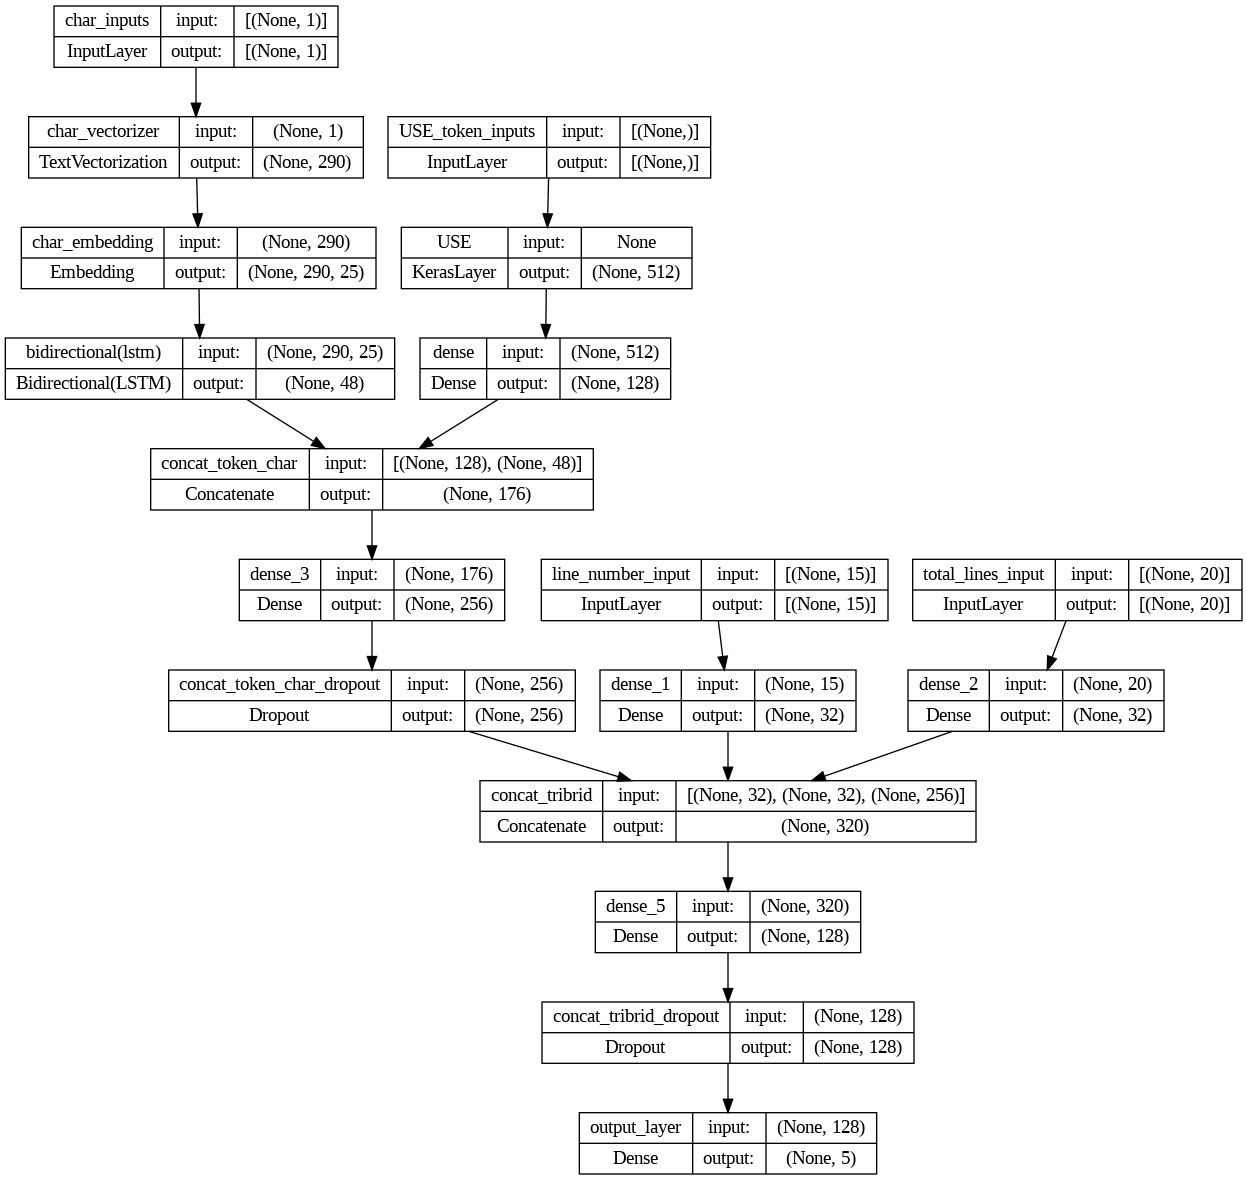

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(tribrid_model,show_shapes=True)

Create tribrid embedding datasets using tf.data

In [27]:
# turn the train, val, and test data samples into fast-loading tf.data Datasets
train_dataset_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                         train_total_lines_one_hot,
                                                         train_sentences,
                                                         train_chars))
train_dataset_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_dataset_data,train_dataset_labels))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                         val_total_lines_one_hot,
                                                         val_sentences,
                                                         val_chars))
val_dataset_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_dataset_data,val_dataset_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                         test_total_lines_one_hot,
                                                         test_sentences,
                                                         test_chars))
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_dataset_data,test_dataset_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Compile, fit, and evaluate tribrid model

In [31]:
# compile token, char, and positional embedding model
tribrid_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# train the model
history_tribrid = tribrid_model.fit(train_dataset,
                                    epochs=3,
                                    steps_per_epoch=int(0.1*len(train_dataset)),
                                    validation_data=val_dataset,
                                    validation_steps=int(0.1*len(val_dataset)),
                                    callbacks=[])

# evaluate the final network on the test samples
tribrid_model_pred_probs_test = tribrid_model.predict(test_dataset)
tribrid_model_preds_test = tf.argmax(tribrid_model_pred_probs_test,axis=1)
tribrid_model_results_test = calculate_results(y_true=test_labels_encoded,
                                               y_pred=tribrid_model_preds_test)
tribrid_model_results_test

Epoch 1/3
562/562 [==============================] - 45s 57ms/step - loss: 0.9022 - accuracy: 0.8461 - val_loss: 0.8829 - val_accuracy: 0.8574
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.8806 - accuracy: 0.8618 - val_loss: 0.8794 - val_accuracy: 0.8610
Epoch 3/3
942/942 [==============================] - 24s 21ms/step


{'accuracy': 85.35589845694376,
 'precision': 0.852899643905327,
 'recall': 0.8535589845694376,
 'f1': 0.853027736483888}

Find the most-wrong predictions

In [32]:
class_names = ["BACKGROUND","CONCLUSIONS","METHODS","OBJECTIVE","RESULTS"]

In [33]:
# find the most wrong predictions from test dataset prediction
# (where the model has predicted the wrong label with the highest prob)

test_predictions_df = test_df 
test_predictions_df["pred"] = tribrid_model_preds_test
test_predictions_df["pred_name"] = [class_names[i] for i in tribrid_model_preds_test]

test_predictions_df["pred_prob"] = np.max(tribrid_model_pred_probs_test)
test_predictions_df["correct"] = test_predictions_df["pred_name"] == test_predictions_df["target"].to_numpy()

test_predictions_df_incorrect = test_predictions_df[test_predictions_df["correct"]==False]
test_predictions_df_incorrect = test_predictions_df_incorrect.sort_values("pred_prob",ascending=False)

test_predictions_df_incorrect.head()

,line_number,target,text,total_lines,pred,pred_name,pred_prob,correct
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,3,OBJECTIVE,0.959539,False
19811,5,METHODS,following a three-week stabilization period ( ...,11,4,RESULTS,0.959539,False
19871,4,RESULTS,"twenty implants ( @ test , @ control ) were pl...",9,2,METHODS,0.959539,False
19860,7,RESULTS,intervention participation was @ % in a hospit...,13,2,METHODS,0.959539,False
19858,5,METHODS,"of these , @,@ were assigned in three spatial ...",13,4,RESULTS,0.959539,False


## Run the full dataset

Extract data

In [34]:
main_data_dir_200k = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

zip_ref = zipfile.ZipFile(main_data_dir_200k+"train.zip")
zip_ref.extractall(main_data_dir_200k)
zip_ref.close()

train_dir_200k = main_data_dir_200k+"train.txt"
val_dir_200k = main_data_dir_200k+"dev.txt"
test_dir_200k = main_data_dir_200k+"test.txt"

train_samples_200k = preprocess_text_with_line_numbers(train_dir_200k)
val_samples_200k = preprocess_text_with_line_numbers(val_dir_200k)
test_samples_200k = preprocess_text_with_line_numbers(test_dir_200k)

train_df_200k = pd.DataFrame(train_samples_200k)
val_df_200k = pd.DataFrame(val_samples_200k)
test_df_200k = pd.DataFrame(test_samples_200k)

train_sentences_200k = train_df_200k["text"].to_list()
val_sentences_200k = val_df_200k["text"].to_list()
test_sentences_200k = test_df_200k["text"].to_list()

Encode labels

In [35]:
# using sklearn.preprocessing.LabelEncoder()
label_encoder = LabelEncoder()
train_labels_encoded_200k = label_encoder.fit_transform(train_df_200k["target"].to_numpy())
val_labels_encoded_200k = label_encoder.fit_transform(val_df_200k["target"].to_numpy())
test_labels_encoded_200k = label_encoder.fit_transform(test_df_200k["target"].to_numpy())

# using sklearn.preprocessing.OneHotEncoder()
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot_200k = one_hot_encoder.fit_transform(train_df_200k["target"].to_numpy().reshape(-1,1))
val_labels_one_hot_200k = one_hot_encoder.fit_transform(val_df_200k["target"].to_numpy().reshape(-1,1))
test_labels_one_hot_200k = one_hot_encoder.fit_transform(test_df_200k["target"].to_numpy().reshape(-1,1))

# using tf.one_hot
train_line_number_one_hot_200k = tf.one_hot(train_df_200k["line_number"].to_numpy(),depth=15)
val_line_number_one_hot_200k = tf.one_hot(val_df_200k["line_number"].to_numpy(),depth=15)
test_line_number_one_hot_200k = tf.one_hot(test_df_200k["line_number"].to_numpy(),depth=15)

train_total_lines_one_hot_200k = tf.one_hot(train_df_200k["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot_200k = tf.one_hot(val_df_200k["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot_200k = tf.one_hot(test_df_200k["total_lines"].to_numpy(),depth=20)

train_chars_200k = [split_chars(sentence) for sentence in train_sentences_200k] 
val_chars_200k = [split_chars(sentence) for sentence in val_sentences_200k]
test_chars_200k = [split_chars(sentence) for sentence in test_sentences_200k]

Create fast-loading tf.data Datasets

In [36]:
# turn the train and val data samples into fast-loading tf.data Datasets
train_dataset_data_200k = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot_200k,
                                                         train_total_lines_one_hot_200k,
                                                         train_sentences_200k,
                                                         train_chars_200k))
train_dataset_labels_200k = tf.data.Dataset.from_tensor_slices(train_labels_one_hot_200k)
train_dataset_200k = tf.data.Dataset.zip((train_dataset_data_200k,train_dataset_labels_200k))
train_dataset_200k = train_dataset_200k.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_data_200k = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot_200k,
                                                         val_total_lines_one_hot_200k,
                                                         val_sentences_200k,
                                                         val_chars_200k))
val_dataset_labels_200k = tf.data.Dataset.from_tensor_slices(val_labels_one_hot_200k)
val_dataset_200k = tf.data.Dataset.zip((val_dataset_data_200k,val_dataset_labels_200k))
val_dataset_200k = val_dataset_200k.batch(32).prefetch(tf.data.AUTOTUNE)

Train the model on the full dataset

In [37]:
# train the model on all of the data using:
# tf.keras.callbacks.ModelCheckpoint
# tf.keras.callbacks.EarlyStopping
# stop the model from training once validation loss has stopped improving over 3 epochs
model_ckpt_path = "/tmp/checkpoint" 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_ckpt_path,
                                                               save_weights_only=True,
                                                               save_best_only=True,
                                                               save_freq="epoch")

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           patience=3)

# train the model
history_tribrid_200k = tribrid_model.fit(train_dataset_200k,
                                    epochs=50,
                                    steps_per_epoch=int(0.1*len(train_dataset_200k)),
                                    validation_data=val_dataset_200k,
                                    validation_steps=int(0.1*len(val_dataset_200k)),
                                    callbacks=[model_checkpoint_callback,
                                               early_stopping_callback])

Epoch 1/50
6912/6912 [==============================] - 334s 48ms/step - loss: 0.8727 - accuracy: 0.8635 - val_loss: 0.8537 - val_accuracy: 0.8733
Epoch 2/50
6912/6912 [==============================] - 330s 48ms/step - loss: 0.8638 - accuracy: 0.8693 - val_loss: 0.8444 - val_accuracy: 0.8795
Epoch 3/50
6912/6912 [==============================] - 347s 50ms/step - loss: 0.8605 - accuracy: 0.8707 - val_loss: 0.8411 - val_accuracy: 0.8833
Epoch 4/50
6912/6912 [==============================] - 342s 49ms/step - loss: 0.8557 - accuracy: 0.8738 - val_loss: 0.8369 - val_accuracy: 0.8823
Epoch 5/50
6912/6912 [==============================] - 367s 53ms/step - loss: 0.8545 - accuracy: 0.8758 - val_loss: 0.8363 - val_accuracy: 0.8840
Epoch 6/50
6912/6912 [==============================] - 373s 54ms/step - loss: 0.8507 - accuracy: 0.8778 - val_loss: 0.8323 - val_accuracy: 0.8868
Epoch 7/50
6912/6912 [==============================] - 342s 49ms/step - loss: 0.8496 - accuracy: 0.8783 - val_loss: 0

6912/6912 [==============================] - 7s 1ms/step - loss: 1.2677 - accuracy: 0.6667 - val_loss: 0.8299 - val_accuracy: 0.8875


In [ ]:
# tribrid_model.save("/content/drive/MyDrive/my_200k_data_trained_model")

Evaluate on the full test dataset

In [38]:
# turn the test data samples into a fast-loading tf.data Dataset
test_dataset_data_200k = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot_200k,
                                                         test_total_lines_one_hot_200k,
                                                         test_sentences_200k,
                                                         test_chars_200k))
test_dataset_labels_200k = tf.data.Dataset.from_tensor_slices(test_labels_one_hot_200k)
test_dataset_200k = tf.data.Dataset.zip((test_dataset_data_200k,test_dataset_labels_200k))
test_dataset_200k = test_dataset_200k.batch(32).prefetch(tf.data.AUTOTUNE)

# evaluate the final network on the test samples
tribrid_model_pred_probs_test_200k = tribrid_model.predict(test_dataset_200k)
tribrid_model_preds_test_200k = tf.argmax(tribrid_model_pred_probs_test_200k,axis=1)
tribrid_model_results_test_200k = calculate_results(y_true=test_labels_encoded_200k,
                                               y_pred=tribrid_model_preds_test_200k)
tribrid_model_results_test_200k


922/922 [==============================] - 24s 26ms/step


{'accuracy': 88.72952904078933,
 'precision': 0.8900000111276817,
 'recall': 0.8872952904078933,
 'f1': 0.8858397444879298}

## Try GloVe embeddings

In [39]:
# check out the keras guide on using pretrained GloVe embeddings
# https://keras.io/examples/nlp/pretrained_word_embeddings/

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

path_to_glove_file = "/content/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word,coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs,"f",sep=" ")
    embeddings_index[word] = coefs

print(f"found {len(embeddings_index)} word vectors.")

inputs = Input(shape=(1,),dtype="string",name="char_inputs")
x = char_vectorizer(inputs)
x = char_embedding(x)
outputs = Bidirectional(LSTM(24))(x) # in paper, 50, which is 2x25
char_model_GLOVE = tf.keras.Model(inputs,outputs,name="char_model")

# vectorization for tokens...
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000 # from paper
output_sequence_length = 48

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_sequence_length)

# adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

voc = text_vectorizer.get_vocabulary()
word_index = dict(zip(voc,range(len(voc))))

num_tokens = len(voc)+2
embedding_dim = 100
hits = 0
misses = 0

# prepare embedding matrix
embedding_matrix = np.zeros((num_tokens,embedding_dim))

for word,i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  
  if embedding_vector is not None:
    # words not found in embedding index will be all zeros.
    # this includes the representation for "padding" and "00V"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1

print(f"converted {hits} words ({misses} misses)")

# you can either fine-tune the embeddings or leave them frozen
new_token_embedding = Embedding(input_dim=num_tokens,
                                output_dim=embedding_dim,
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                trainable=False,
                                name="token_embedding_GLOVE")

# to finish this out, we would need to:
# create a new token_model_GLOVE
inputs = Input(shape=(1,),dtype="string",name="tribrid_GLOVE_inputs")
x = text_vectorizer(inputs)
x = new_token_embedding(x)
outputs = Bidirectional(LSTM(24))(x) # in paper, 50, which is 2x25
# outputs = Dense(128,activation="relu")(x)
token_model_GLOVE = tf.keras.Model(inputs,outputs,name="token_model_GLOVE")

# re-concatenate token and char models
concat_token_char_GLOVE = Concatenate(name="concat_token_char_GLOVE")([token_model_GLOVE.output,
                                                                       char_model_GLOVE.output])

# add dropout and dense layers
x = Dense(256,activation="relu")(concat_token_char_GLOVE)
concat_token_char_GLOVE_embedding = Dropout(0.5,name="concat_token_char_GLOVE_embedding")(x)

# re-concatenate combo with line number and total lines models
concat_tribrid_GLOVE = Concatenate(name="concat_tribrid_GLOVE")([line_number_model.output,
                                                                 total_lines_model.output,
                                                                 concat_token_char_GLOVE_embedding])
# add final dense layer
tribrid_GLOVE_output = Dense(5,activation="softmax",name="tribrid_GLOVE_output")(concat_tribrid_GLOVE)

# create the model
tribrid_model_GLOVE = tf.keras.Model([line_number_model.input,
                                      total_lines_model.input,
                                      token_model_GLOVE.input,
                                      char_model_GLOVE.input],
                                     tribrid_GLOVE_output,
                                     name="tribrid_model_GLOVE")

# compile the model
tribrid_model_GLOVE.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

# original datasets should be fine... haven't overwritten yet
# fit the model
history_tribrid_model_GLOVE = tribrid_model_GLOVE.fit(train_dataset,
                                                      epochs=3,
                                                      steps_per_epoch=int(0.1*len(train_dataset)),
                                                      validation_data=val_dataset,
                                                      validation_steps=int(0.1*len(val_dataset)),
                                                      callbacks=[])
# evaluate
tribrid_model_GLOVE_pred_probs = tribrid_model_GLOVE.predict(val_dataset)
tribrid_model_GLOVE_preds = tf.argmax(tribrid_model_GLOVE_pred_probs,axis=1)
tribrid_model_GLOVE_results = calculate_results(y_true=val_labels_encoded,
                                                y_pred=tribrid_model_GLOVE_preds)
tribrid_model_GLOVE_results

--2023-03-01 23:11:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-01 23:11:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-01 23:11:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

{'accuracy': 84.15199258572753,
 'precision': 0.8411268700202892,
 'recall': 0.8415199258572753,
 'f1': 0.8410167587097344}

In [40]:
token_model_GLOVE.summary()

Model: "token_model_GLOVE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tribrid_GLOVE_inputs (Input  [(None, 1)]              0         
 Layer)                                                          
                                                                 
 text_vectorization (TextVec  (None, 48)               0         
 torization)                                                     
                                                                 
 token_embedding_GLOVE (Embe  (None, 48, 100)          6484300   
 dding)                                                          
                                                                 
 bidirectional_2 (Bidirectio  (None, 48)               24000     
 nal)                                                            
                                                                 
Total params: 6,508,300
Trainable params: 24,000


In [41]:
char_model_GLOVE.summary()

Model: "char_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_inputs (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 bidirectional_1 (Bidirectio  (None, 48)               9600      
 nal)                                                            
                                                                 
Total params: 10,300
Trainable params: 10,300
Non-trainable params: 0
_________________________________________________________________


## Try BERT

In [43]:
# try replacing the tensorflow hub USE pretrained embedding for the
# tensorflow hub BERT PubMed expert pretrained embedding:
# https://tfhub.dev/google/experts/bert/pubmed/2

# PREVIOUS:
  # # create a token-level model (USE)
  # import tensorflow_hub as hub
  # use_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
  #                                    trainable=False,
  #                                    name="USE")

  # from tensorflow.keras.layers import Input, Dense
  # inputs = Input(shape=[],dtype="string",name="USE_token_inputs")
  # x = use_encoder_layer(inputs)
  # outputs = Dense(128,activation="relu")(x)
  # token_model_USE = tf.keras.Model(inputs,outputs,name="token_model_USE")

!pip3 install --quiet tensorflow-text
import tensorflow_text as text # imports tf ops for preprocessing

# load BERT encoder and preprocessing models
# bert = hub.load("https://tfhub.dev/google/experts/bert/pubmed/2")

preprocess_handle = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_handle = hub.load("https://tfhub.dev/google/experts/bert/pubmed/2")

inputs = Input(shape=(),dtype="string",name="BERT_inputs")
preprocessing_layer = hub.KerasLayer(preprocess_handle, name='preprocessing')
encoder_inputs = preprocessing_layer(inputs)

encoder = hub.KerasLayer(bert_handle, trainable=False, name='BERT_encoder')
outputs_BERT = encoder(encoder_inputs)

x = outputs_BERT['pooled_output']
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(128, activation="relu", name='BERT_outputs')(x)
token_model_BERT = tf.keras.Model(inputs,outputs,name="token_model_BERT")

# does this affect results?
# NEED TO FINISH THE REST OF INIT TO SEE...
# re-concatenate token and char models
concat_token_char_BERT = Concatenate(name="concat_token_char_BERT")([token_model_BERT.output,
                                                                     char_model.output])

# incorporate the dropout and dense layers
x = Dense(256,activation="relu")(concat_token_char_BERT)
concat_token_char_BERT_embedding = Dropout(0.5,name="concat_token_char_BERT_embedding")(x)

# re-concatenate combined token and char models with line_number and total_lines models
concat_tribrid_BERT = Concatenate(name="concat_tribrid_BERT")([line_number_model.output,
                                                               total_lines_model.output,
                                                               concat_token_char_BERT_embedding])

tribrid_BERT_output = Dense(5,activation="softmax",name="tribrid_BERT_output")(concat_tribrid_BERT)
tribrid_model_BERT = tf.keras.Model([line_number_model.input,
                                     total_lines_model.input,
                                     token_model_BERT.input,
                                     char_model.input],
                                    tribrid_BERT_output,
                                    name="tribrid_model_BERT")

# compile the new model
tribrid_model_BERT.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# note: using BERT requires an extra preprocessing step for sequences,
# as detailed here: https://tfhub.dev/google/experts/bert/pubmed/2

# convert the sentences into bert inputs
# (previous USE inputs were just the sentences... comes up in dataset generation)
# train_bert_sentences = preprocess(train_sentences)
# val_bert_sentences = preprocess(val_sentences)
# test_bert_sentences = preprocess(test_sentences)

# dataset change: instead of incorporating train_sentences, need train_bert_sentences
train_dataset_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                         train_total_lines_one_hot,
                                                         train_sentences,
                                                         train_chars))
train_dataset = tf.data.Dataset.zip((train_dataset_data,train_dataset_labels)) # old set of labels works fine
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                         val_total_lines_one_hot,
                                                         val_sentences,
                                                         val_chars))
val_dataset = tf.data.Dataset.zip((val_dataset_data,val_dataset_labels)) # old set of labels works fine
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                         test_total_lines_one_hot,
                                                         test_sentences,
                                                         test_chars))
test_dataset = tf.data.Dataset.zip((test_dataset_data,test_dataset_labels)) # old set of labels works fine
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# fit as usual, with these new dataset definitions
history_tribrid_model_BERT = tribrid_model_BERT.fit(train_dataset,
                                                    epochs=3,
                                                    steps_per_epoch=int(0.1*len(train_dataset)),
                                                    validation_data=val_dataset,
                                                    validation_steps=int(0.1*len(val_dataset)),
                                                    callbacks=[])

# evaluate
tribrid_model_BERT_pred_probs = tribrid_model_BERT.predict(val_dataset)
tribrid_model_BERT_preds = tf.argmax(tribrid_model_BERT_pred_probs,axis=1)
tribrid_model_BERT_results = calculate_results(y_true=val_labels_encoded,
                                               y_pred=tribrid_model_BERT_preds)
tribrid_model_BERT_results


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 53.8 MB/s eta 0:00:00
Epoch 1/3
562/562 [==============================] - 272s 443ms/step - loss: 0.9701 - accuracy: 0.8187 - val_loss: 0.8769 - val_accuracy: 0.8743
Epoch 2/3
562/562 [==============================] - 254s 453ms/step - loss: 0.8900 - accuracy: 0.8722 - val_loss: 0.8615 - val_accuracy: 0.8823
Epoch 3/3
945/945 [==============================] - 331s 345ms/step


{'accuracy': 88.66675493181518,
 'precision': 0.8858008891123565,
 'recall': 0.8866675493181517,
 'f1': 0.8858523279652152}

## Aside: various model option examples

Binary LSTM

In [ ]:
# binary LSTM:
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64,return_sequences=True)(x) # to return vector for each word
x = layers.LSTM(64)(x) # return vector for whole sequence
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.Model(inputs,outputs,name="model")

Binary GRU

In [ ]:
# binary GRU
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64,return_sequences=True)(x) # to return vector for each word
x = layers.GRU(64)(x) # return vector for whole sequence
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.Model(inputs,outputs,name="model")

Binary CNN

In [ ]:
# use RNNs, LSTMs, GRUs, and CNNs in models that work with text
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32,kernel_size=5,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.Model(inputs,outputs,name="model")